Ссылка на презентацию: https://drive.google.com/file/d/1wTQmwzeYKYQEtHKGVXu4XGAcmeS-4GfG/view?usp=sharing

# Выявление профилей потребления

Есть данные интернет-магазина товаров для дома за период с октября 2018 года по январь 2020 года включительно, необходимо сегментировать покупателей по профилю потребления для персонализации предложений пользователям и рекомендациям по работе с разными категориями клиентов

## Загрузка данных и изучение общей информации

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
from datetime import datetime, timedelta
from scipy.stats import binom, norm
from math import sqrt

In [2]:
try:
    ecom = pd.read_csv('/datasets/ecom_dataset_upd.csv')
except:
    ecom = pd.read_csv('https://code.s3.yandex.net/datasets/ecom_dataset_upd.csv')

In [3]:
ecom.head()

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


In [4]:
ecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         7474 non-null   int64  
 1   customer_id  7474 non-null   object 
 2   order_id     7474 non-null   int64  
 3   product      7474 non-null   object 
 4   quantity     7474 non-null   int64  
 5   price        7474 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 350.5+ KB


<div style="border: solid purple 2px; padding: 20px">В таблице ecom 7474 строки, таблица содержит информацию о дате заказа, идентификаторе покупателя, идентификаторе заказа, наименовании товара, количестве товара в заказе и цене товара. Пропусков нет, необходимо изменить тип данных для колонки с датой заказа.

## Предобработка данных

### Изменение типов данных

In [5]:
ecom['date'] = pd.to_datetime(ecom['date'], format='%Y%m%d%H')

In [6]:
ecom.head(10) # проверка

,date,customer_id,order_id,product,quantity,price
0,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0
5,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Шеффлера Лузеана d-9 см,1,164.0
6,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Юкка нитчатая d-12 см h-25-35 см,1,134.0
7,2018-10-01 08:00:00,375e0724-f033-4c76-b579-84969cf38ee2,68479,Настенная сушилка для белья Gimi Brio Super 100,1,824.0
8,2018-10-01 08:00:00,6644e5b4-9934-4863-9778-aaa125207701,68478,"Таз пластмассовый 21,0 л круглый ""Водолей"" С61...",1,269.0
9,2018-10-01 09:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,68480,Чехол для гладильной доски Colombo Persia Beig...,1,674.0


Тип данных нужно изменить для корректности работы с данными даты, например для получения информации по годам, месяцам или дням

### Обработка дубликатов

In [7]:
ecom.duplicated().sum()

0

Явных дубликатов нет, поищем дубликаты по сумме ключевых параметров. Одинаковыми будем считать заказы с одним идентификатором пользователя, номером заказа и продуктом

In [8]:
ecom[ecom.duplicated(subset=['customer_id', 'order_id', 'product'], keep=False)].head(10)

,date,customer_id,order_id,product,quantity,price
15,2018-10-01 18:00:00,17213b88-1514-47a4-b8aa-ce51378ab34e,68476,"Мини-сковорода Marmiton ""Сердце"" с антипригарн...",1,239.0
16,2018-10-01 18:00:00,17213b88-1514-47a4-b8aa-ce51378ab34e,68476,Сковорода алюминиевая с антипригарным покрытие...,1,824.0
17,2018-10-01 18:00:00,17213b88-1514-47a4-b8aa-ce51378ab34e,68476,Стеклянная крышка для сковороды ALPENKOK 26 см...,1,262.0
18,2018-10-01 18:00:00,17213b88-1514-47a4-b8aa-ce51378ab34e,68476,"Сушилка для белья напольная Colombo Star 18, 3679",1,1049.0
19,2018-10-01 21:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0
58,2018-10-02 18:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0
59,2018-10-02 19:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0
60,2018-10-02 20:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0
63,2018-10-03 04:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0
80,2018-10-04 09:00:00,32de7df8-8d4f-4c84-a7b9-c41d00dd83ba,68522,Эвкалипт Гунни d-17 см h-60 см,1,1409.0


Видно, что некоторые заказы (в частности, заказ под номером 68474) продублированы аж четыре раза, но в разное время. Будем считать дубликатами все одинаковые заказы, кроме первого.

In [9]:
ecom = ecom.drop_duplicates(subset=['customer_id', 'order_id', 'product'], keep='first')

In [10]:
ecom.query('order_id == 68474') # проверим, что осталось только первое вхождение

,date,customer_id,order_id,product,quantity,price
19,2018-10-01 21:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0


Так же известно, что был сделан один технический заказ на самое большое количество товаров, его так же следует найти и удалить

In [11]:
ecom.sort_values(by='quantity', ascending=False).head(5)

,date,customer_id,order_id,product,quantity,price
5456,2019-06-18 15:00:00,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"Вантуз с деревянной ручкой d14 см красный, Bur...",1000,675.0
5071,2019-06-11 07:00:00,146cd9bf-a95c-4afb-915b-5f6684b17444,71668,Вешалки мягкие для деликатных вещей 3 шт шоколад,334,148.0
3961,2019-05-20 21:00:00,5d189e88-d4d6-4eac-ab43-fa65a3c4d106,71478,Муляж ЯБЛОКО 9 см красное,300,51.0
1158,2018-12-10 14:00:00,a984c5b7-ff7e-4647-b84e-ef0b85a2762d,69289,"Ручка-скоба РС-100 белая *Трибатрон*, 1108035",200,29.0
568,2018-11-01 08:00:00,aa42dc38-780f-4b50-9a65-83b6fa64e766,68815,Муляж ЯБЛОКО 9 см красное,170,51.0


Удалим технический заказ с номером 71743 

In [12]:
ecom = ecom.query('order_id != 71743')

In [13]:
ecom.query('order_id == 71743') # проверка

,date,customer_id,order_id,product,quantity,price


Выясним, есть ли заказы, которые имеют одинаковый идентифика
тор заказа, но разные идентификаторы пользователя

In [14]:
ecom.pivot_table(index=['order_id'], values=['customer_id'], aggfunc={'customer_id':'nunique'})\
.sort_values(by='customer_id', ascending=False).head()

,customer_id
order_id,
72845,4
71480,3
69485,3
70903,2
71571,2


Найдем все идентификаторы таких заказов

In [15]:
ecom.pivot_table(index=['order_id'], values=['customer_id'], aggfunc={'customer_id':'nunique'}).query('customer_id>1').index

Int64Index([14872, 68785, 69283, 69310, 69345, 69410, 69485, 69531, 69833,
            70114, 70542, 70631, 70726, 70808, 70903, 70946, 71054, 71226,
            71461, 71480, 71542, 71571, 71648, 71663, 72188, 72778, 72790,
            72845, 72950],
           dtype='int64', name='order_id')

Найдем дубликаты по двум параметрам: идентификатора заказа и названию продукта и посмотрим, какие эти заказы имеют идентификаторы заказа

In [16]:
ecom[ecom.duplicated(subset=['order_id', 'product'], keep=False)]['order_id'].unique() 

array([68785, 69283, 69310, 69345, 69410, 69485, 69531, 69833, 70114,
       70542, 70631, 70726, 70808, 70903, 70946, 71054, 71226, 71461,
       71480, 71542, 71571, 71648, 71663, 14872, 72188, 72778, 72790,
       72845, 72950], dtype=int64)

Так как это одни и те же заказы, оставим те, которые были оформлены раньше

In [17]:
ecom = ecom.drop_duplicates(subset=['order_id', 'product'], keep='first')

In [18]:
ecom.pivot_table(index=['order_id'], values=['customer_id'], aggfunc={'customer_id':'nunique'})\
.sort_values(by='customer_id', ascending=False).head() # проверка

,customer_id
order_id,
69485,2
12624,1
72312,1
72315,1
72320,1


Посмотрим, что остался за заказ

In [19]:
ecom.query('order_id == 69485')

,date,customer_id,order_id,product,quantity,price
1282,2018-12-20 16:00:00,5be0f4b4-947f-4672-b147-73ef5936ecd4,69485,Набор столовых приборов 24 предмета SAINT GERM...,1,1087.0
1292,2018-12-21 11:00:00,266beb08-ec9b-43b4-89bb-ac60fa23ffee,69485,Набор столовых приборов 24 предмета FARANDOLE ...,1,1274.0


Дубликат не удалился, потому что изменился заказываемый продукт, это возможно связано с ошибкой, из-за которой возникает дубликаты уникальных идентификаторов заказа. Возможно проблема возникает при переоформлении заказа каким-либо образом. Удалим заказ вручную

In [20]:
ecom = ecom.query('order_id != 69485 & customer_id !="266beb08-ec9b-43b4-89bb-ac60fa23ffee"')

In [21]:
ecom = ecom.reset_index()

In [22]:
ecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5551 entries, 0 to 5550
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   index        5551 non-null   int64         
 1   date         5551 non-null   datetime64[ns]
 2   customer_id  5551 non-null   object        
 3   order_id     5551 non-null   int64         
 4   product      5551 non-null   object        
 5   quantity     5551 non-null   int64         
 6   price        5551 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 303.7+ KB


<div style="border: solid purple 2px; padding: 20px">После обработки дубликатов в таблице осталось 5550 строк, на дубликаты пришлось около 25% данных. Стоит обязательно обратить внимание на проблему повторной выгрузки и на повторение уникальных идентификаторов заказов.

### Добавление столбцов

#### Столбцы с элементами даты

In [23]:
ecom['year'] = pd.DatetimeIndex(ecom['date']).year # добавляем столбец с годом

In [24]:
ecom['month'] = pd.DatetimeIndex(ecom['date']).month # добавляем столбец с месяцем 

In [25]:
ecom['date'] = pd.to_datetime(ecom['date']).dt.date

In [26]:
ecom.head() # проверка

,index,date,customer_id,order_id,product,quantity,price,year,month
0,0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,2018,10
1,1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,2018,10
2,2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,2018,10
3,3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,2018,10
4,4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,2018,10


#### Столбец с стоимостью товаров в заказе

Добавим столбец, в котором будет стоимость товаров с учетом их количества

In [27]:
ecom['cost'] = ecom['quantity']*ecom['price']

#### Столбец с категорией товаров

Для удобства приведем все названия товаров к нижнему регистру

In [28]:
ecom['product'] = ecom['product'].str.lower()

Просмотрим все товары, которые были хоть раз проданы

In [29]:
np.set_printoptions(threshold=np.inf)

In [30]:
np.array(sorted(ecom['product'].unique()))

array(['tepмокружка avex freeflow 700 мл зеленый avex0759',
       'tepмокружка avex freeflow 700 мл сталь avex0776',
       'tepмокружка avex recharge 500 мл голубой avex0681',
       'автоматическая щетка leifheit для мытья окон с ручкой 43 см. 51114',
       'агератум рассада однолетних цветов в кассете по 10 шт',
       'адиантум лиза d-12 см', 'азалия индика биколор d-12 см',
       'азалия индика биколор d-12 см h-20',
       'азалия индика розовая d-12 см h-20',
       'азалия индика фиолетовая d-10 см h-20',
       'аквилегия махровая тауэр смесь окрасок объем 1 л',
       'аквилегия обыкновенная барлоу микс объем 1 л',
       'алиссум (лобулярия) снежные одежды 0,2 г 4650091480302',
       'алиссум рассада однолетних цветов в кассете по 10 шт',
       'алиссум рассада однолетних цветов в кассете по 6 шт',
       'алиссум скальный желтый объем 1 л', 'алоэ вера d-12 см h-25 см',
       'альбука спиралис фризл-сизл d-12 см',
       'амариллис red lion темно-красный в горшке d-12 

Создадим списки товаров для каждой категории, кроме категории "растения и рассада", она будет присваиваться всему, чему не присвоена категория до этого. Категории будут следующие:
- инвентарь для уборки;
- текстиль;
- декор и интерьер;
- посуда;
- хранение вещей;
- аксессуары для ванны;
- кухонные принадлежности;
- ремонт и строительство;
- растеня и рассада;
- другое.

In [31]:
interior_tuple = ('ваза', 'декоративная', 'искусственная', 'искусственный', 'муляж', 'новогоднее дерево', 
                 'обувница-3', 'подкладка под чехол', 'подставка для обуви', 'подставка для цветов', 
                'подставка для яйца', 'светильник', 'складной детский пуф', 'фоторамка', 'цветок искусственный', 
                'карниз алюминиевый', 'карниз алюминиевый')

In [32]:
bath_accessories_tuple = ('бак для белья', 'бельевые прищепки', 'ванна', 'вантуз', 'держатель для туалетной бумаги', 'дозатор для мыла',
                        'запасная насадка для ерша', 'зубная паста', 'карниз для ванной', 'коврик для ванны', 'ковш', 
                         'комплект для ванной','корзина для белья', 'корыто', 'мыльница', 'ковров для ванной', 
                         'набор прищепок', 'паста зубная', 'пена для ванн', 'подголовник для ванной комнаты', 
                         'прищепки для белья', 'пробка для ванны', 'сиденье', 'сушилка',
                         'штанга для ванной', 'штора для ванной', 'штора со встроенными', 'штора текстильная')

In [33]:
cleaning_equipment_tuple = ('щетка', 'антижир','антинакипин', 'ароматизированное средство', 'бальзам для мытья', 'гладильная доска',\
                          'губка', 'жидкое мыло', 'комплект для мытья полов', 'кондиционер для белья', 'концентрат',\
                          'мыло жидкое', 'мыло ручной работы', 'мыло-скраб', 'швабра', 'насадка', 'нетканые салфетки',
                          'окномойка', 'отбеливатель', 'отжим для ведра', 'перчатки', 'пылесос', 'ролик для чистки', 'рукав для гладильной доски',
                          'сиденье для гладильной доски', 'скребок', 'сменная насадка к швабре', 'сменный блок для ролика', 'сметка с совком',
                          'совок', 'средство для', 'средство против', 'стакан для ванной', 'стиральный', 'гладильная', 
                          'таз', 'универсальное средство', 'чистящий крем', 'швабра', 'щетка', 'ёрш', 'ерш', 'сетка для стирки')

In [34]:
kitchenware_tuple = ('весы электронные кухонные', 'вкладыши для хранения посуды', 'доска разделочная',
                    'емкость для свч', 'защитная соль', 'защитный экран', 'измельчитель','картофелемялка', 'кастрюля',
                    'кипятильник', 'кисточка силиконовая','котел', 'кувшин', 'кухонные ножницы', 'лопатка c прорезями',
                    'миксер', 'мини-сковорода', 'набор ножей', 'набор форм', 'нож', 'овощеварка', 'овощечистка', 
                    'ополаскиватель для посудомоечных машин', 'отделитель косточек','орехоколка', 'подставка для ножей', 'половник', 
                    'пресс для чеснока', 'просеиватель для муки','противень', 'разделочная доска','рассекатель пламени', 
                    'рыбочистка', 'сахарница', 'сито', 'скалка', 'сковорода', 'соковарка', 'стеклянная крышка', 'соковыжималка', 'сотейник', 
                    'стакан', 'столовая', 'столовый',  'терка', 'термометр', 'толкушка', 'универсальный нож', 
                    'форма', 'хлебница','чайная ложка', 'чайник', 'шприц кондитерский', 'электроштопор')

In [35]:
tableware_tuple = ('блюдо', 'бульонница', 'вилка', 'емкость для соуса', 'кружка',  'ложка кухонная', 'ложка столовая', 'ложка чайная',
                 'миска',  'набор бокалов', 'кружек для пива', 'набор посуды', 'набор стаканов', 'набор столовых',  'набор фужеров',
                 'набор эмалированных салатников', 'салатник', 'термокружка', 'термостакан', 'фарфоровая кружка', 'чайная ложка',
                 'чайный', 'tepмокружка', 'тарелка')

In [36]:
storage_tuple = ('банка', 'бидон', 'пакет', 'ведро', 'вешалка', 'жестяная банка', 'контейнер', 'корзина', 'корзинка', 'короб', 'кофр',\
               'лоток', 'мешок', 'стеклянная банка', 'мусорный контейнер', 'набор вешалок', 'плечики пластмассовые', 'полка для обуви',
               'полки','складная картонная коробка', 'стеллаж для обуви', 'сумка', 'тележка', 'чехол для короткой одежды', 'чехол для костюма',
               'чехол для одежды', 'чехол для платья', 'этажерка', 'ящик для хранения')

In [37]:
textile_tuple = ('наволочка', 'наматрасник', 'одеяло', 'плед флисовый', 'пододеяльник', 'подушка', 'покрывало', 'полотенце', 'простынь',
               'простыня', 'двуспальное постельное белье', 'комплект постельного белья', 'комплект махровых', 'кухонное полотенце',
                'лен небесная лазурь','ткань', 'халат вафельный', 'кухонных полотенец', 'махровых салфеток',  'салфетка', 'скатерть',
               'ткань', 'ковер придверный', 'коврик ворсовый пвх придверный', 'коврик интерьерный', 'коврик кухонный', 'коврик придверный', 
                'коврик хлопковый', 'ковёр', 'коврик')

In [38]:
construction_tuple = ('завертка', 'измерительный', 'крепеж', 'лестница', 'линейка','многофункциональный инструмент',
                    'набор инструментов', 'набор прецизионных напильников','набор сверел', 'петля', 'пружина дверная',
                    'решетка вентиляционная', 'ручка', 'сверло', 'стремянка', 'стяжка', 'фал капроновый', 'шпингалет', 
                     'штангенциркуль', 'холодная сварка')

In [39]:
other_tuple = ('весы напольные', 'доска гладильная', 'кольца для штор', 'комод', 'крышка', 'крючок', 'ложка обувная',
              'набор для пикника', 'настенная сушилка', 'настольная гладильная', 'основание для пробки', 'паста для полировки', 
               'подголовник', 'подрукавник', 'покрытие для гладильной доски', 'пьезозажигалка', 'термометр', 'увлажняющая маска',
              'урна', 'утюг', 'фен дорожный', 'шило', 'шнур', 'шпагат', 'ящик почтовый', 'чехол для гладильной доски', 'чехол')

In [40]:
category_dict = {cleaning_equipment_tuple: 'инвентарь для уборки',
                textile_tuple: 'текстиль',
                interior_tuple: 'декор и интерьер',
                tableware_tuple: 'посуда',
                 storage_tuple: 'хранение вещей',
                 bath_accessories_tuple: 'аксессуары для ванны', 
                 kitchenware_tuple: 'кухонные принадлежности',
                 construction_tuple: 'ремонт и строительство',
                 other_tuple: 'другое'}

In [41]:
def categorize_product(row):
    for i in category_dict.keys():
        for j in i:
            if j in row:
                return category_dict[i]
    return 'растения и саженцы'

In [42]:
ecom['category'] = ecom['product'].apply(categorize_product)

Проверим, как отработала функция

In [43]:
pd.set_option('display.max_rows', 200)

In [44]:
ecom.head(200)

,index,date,customer_id,order_id,product,quantity,price,year,month,cost,category
0,0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,2018,10,142.0,растения и саженцы
1,1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.0,2018,10,194.0,растения и саженцы
2,2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,2018,10,112.0,растения и саженцы
3,3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0,2018,10,179.0,растения и саженцы
4,4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0,2018,10,112.0,растения и саженцы
5,5,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,шеффлера лузеана d-9 см,1,164.0,2018,10,164.0,растения и саженцы
6,6,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,юкка нитчатая d-12 см h-25-35 см,1,134.0,2018,10,134.0,растения и саженцы
7,7,2018-10-01,375e0724-f033-4c76-b579-84969cf38ee2,68479,настенная сушилка для белья gimi brio super 100,1,824.0,2018,10,824.0,аксессуары для ванны
8,8,2018-10-01,6644e5b4-9934-4863-9778-aaa125207701,68478,"таз пластмассовый 21,0 л круглый ""водолей"" с61...",1,269.0,2018,10,269.0,инвентарь для уборки
9,9,2018-10-01,c971fb21-d54c-4134-938f-16b62ee86d3b,68480,чехол для гладильной доски colombo persia beig...,1,674.0,2018,10,674.0,другое


In [45]:
pd.set_option('display.max_rows', 50)

#### Столбец с ценовой категорией товаров

Напишем функцию, разделяющую товары на разные ценовые категории:
- до 100;
- от 100 до 1000;
- от 1000.

In [46]:
def categorize_price(price):
    if 0 <= price < 100:
        return 'до 100'
    elif 100 <= price < 1000:
        return 'от 100 до 1000'
    return 'от 1000'

In [47]:
ecom['price_category'] = ecom['price'].apply(categorize_price)

In [48]:
ecom.head() # проверка работы

,index,date,customer_id,order_id,product,quantity,price,year,month,cost,category,price_category
0,0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,2018,10,142.0,растения и саженцы,от 100 до 1000
1,1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.0,2018,10,194.0,растения и саженцы,от 100 до 1000
2,2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,2018,10,112.0,растения и саженцы,от 100 до 1000
3,3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0,2018,10,179.0,растения и саженцы,от 100 до 1000
4,4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0,2018,10,112.0,растения и саженцы,от 100 до 1000


## Исследовательский анализ данных 

### Количество пользователей 

Посмотрим, когда был совершен первый и последний заказ 

In [49]:
min_date = ecom['date'].min()

In [50]:
max_date = ecom['date'].max()

In [51]:
f'Первый заказ совершили {min_date}, последний - {max_date}'

'Первый заказ совершили 2018-10-01, последний - 2020-01-31'

Посчитаем, сколько всего уникальных пользователей в таблице

In [52]:
ecom['customer_id'].nunique()

2429

Всего в таблице 2427 уникальных покупателей

Определим дату первой покупки для каждого пользователя, будм считать это первым появлением пользователя

In [53]:
first_purchase = ecom.sort_values(by=['customer_id', 'date']).groupby('customer_id').agg({'date': 'first'}).reset_index()

In [54]:
first_purchase['year'] = pd.DatetimeIndex(first_purchase['date']).year

In [55]:
first_purchase['month'] = pd.DatetimeIndex(first_purchase['date']).month

In [56]:
first_purchase.head()

,customer_id,date,year,month
0,000d6849-084e-4d9f-ac03-37174eaf60c4,2019-10-16,2019,10
1,001cee7f-0b29-4716-b202-0042213ab038,2019-02-16,2019,2
2,00299f34-5385-4d13-9aea-c80b81658e1b,2019-10-14,2019,10
3,002d4d3a-4a59-406b-86ec-c3314357e498,2019-01-27,2019,1
4,003bbd39-0000-41ff-b7f9-2ddaec152037,2019-09-29,2019,9


In [57]:
first_purchase.pivot_table(index=['year', 'month'], values=['customer_id'], aggfunc={'customer_id': 'count'})

customer_id
year month             
2018 10             180
     11             177
     12             231
2019 1              146
     2              241
     3              226
     4              227
     5              161
     6              148
     7              183
     8              161
     9              172
     10             165
     11               3
     12               3
2020 1                5

Видно, что после октября 2019 года новых пользователей совершили всего 8 заказов. На это стоит обратить внимание.

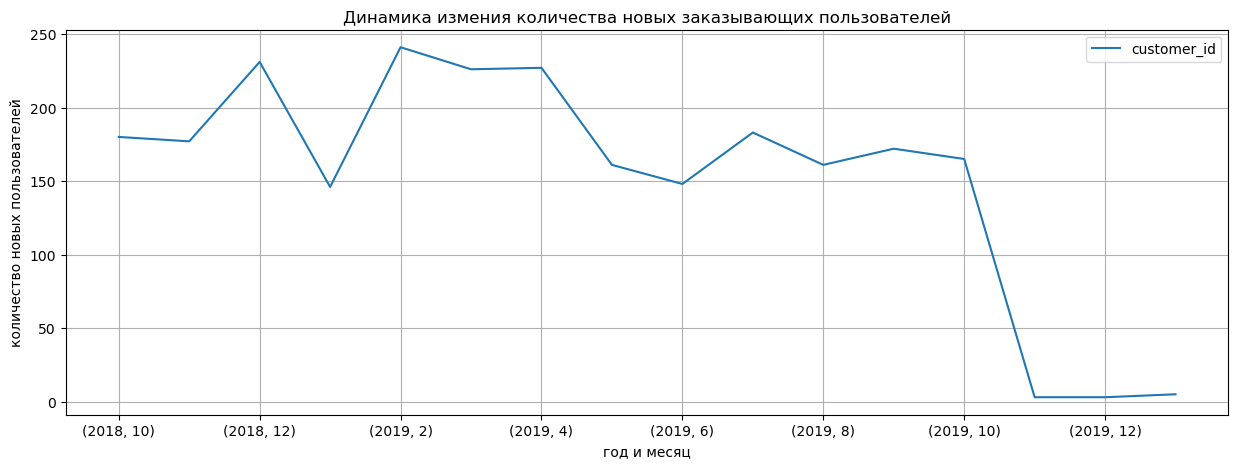

In [58]:
first_purchase.pivot_table(index=['year', 'month'], values=['customer_id'], aggfunc={'customer_id': 'count'})\
.plot(y='customer_id', grid=True, figsize=(15, 5))
plt.ylabel("количество новых пользователей")
plt.xlabel("год и месяц")
plt.title("Динамика измения количества новых заказывающих пользователей");

<div style="border: solid purple 2px; padding: 20px"> Всего  за исследуемый период 2427 уникальных покупателя. Пик новых заказывающих пользователей пришелся на февраль 2019 года (242 пользователя), это количество держалось на примерно таком же уровне еще март и апрель (226 и 226 новых заказывающих пользователей соответсвенно). В ноябре 2019 года виден резкий спад новых покупающих пользователей, по какой причине - не ясно. 

### Количество и доли товаров в категориях

In [59]:
ecom.groupby('category')['product'].nunique().sort_values(ascending=False)

category
растения и саженцы         952
хранение вещей             281
аксессуары для ванны       218
инвентарь для уборки       210
текстиль                   159
декор и интерьер           150
кухонные принадлежности    117
посуда                     114
другое                      81
ремонт и строительство      56
Name: product, dtype: int64

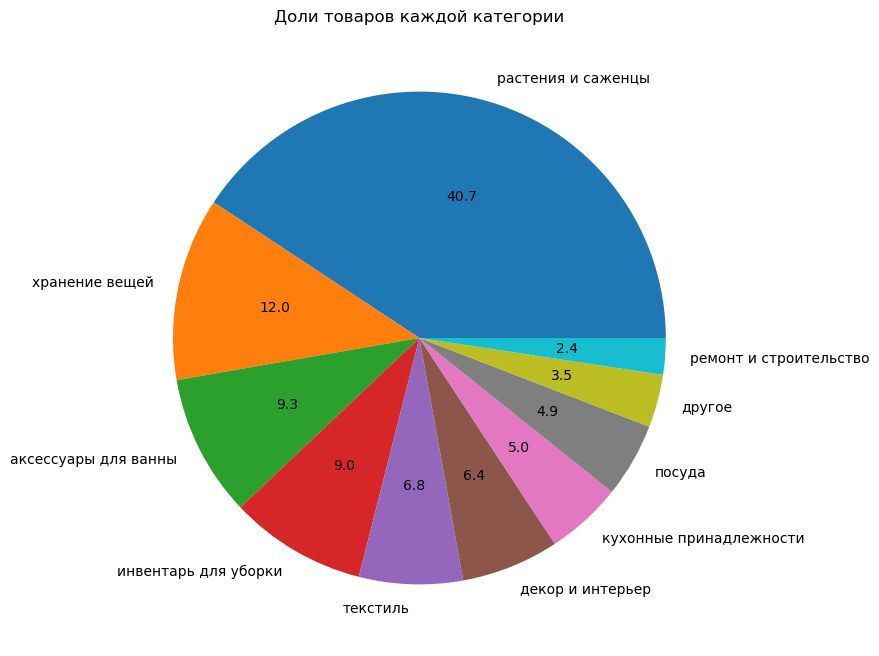

In [60]:
ecom.groupby('category')['product'].nunique().sort_values(ascending=False).plot(kind='pie', autopct='%.1f', figsize = (15,8), legend=False).set(ylabel='')
plt.title("Доли товаров каждой категории");

<div style="border: solid purple 2px; padding: 20px">Практически половина всех предоставляемых товаров это товары, относящиеся к категории "растеня и саженцы" (40,7% или 952 товара), так же часть товаров (12,0% или 281 товара) относится к категории "хранение вещей" и аксессуары для ванны (9,3% или 218 товаров). Меньше всего товаров в категории "ремонт и строительство" (2,4% или 56 товаров).

### Количество и доли товаров в разных ценовых категориях

In [61]:
ecom.groupby('price_category')['product'].nunique().sort_values(ascending=False)

price_category
от 100 до 1000    1281
до 100             655
от 1000            421
Name: product, dtype: int64

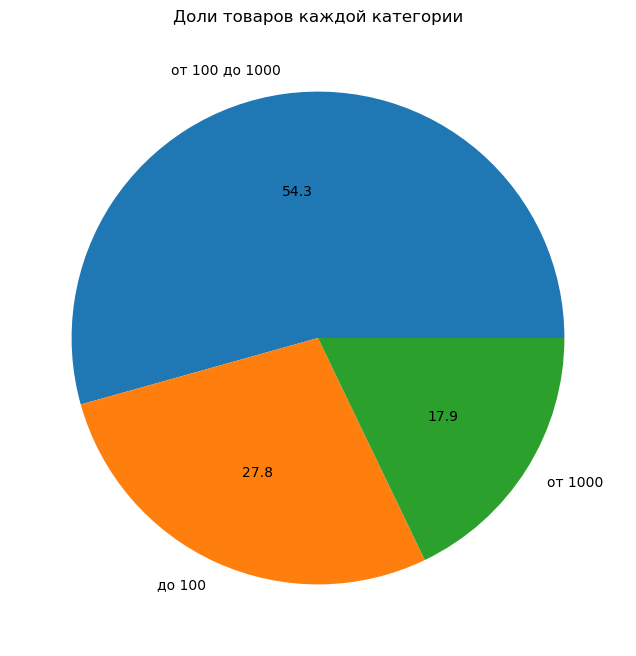

In [62]:
ecom.groupby('price_category')['product'].nunique().sort_values(ascending=False).plot(kind='pie', autopct='%.1f', figsize = (15,8), legend=False).set(ylabel='')
plt.title("Доли товаров каждой категории");

<div style="border: solid purple 2px; padding: 20px">Большинство товаров (54,3% или 1281 товао) относится к ценовой категории "от 100 до 1000", так же значительную часть товаров составляют товары в ценовой категории "до 100" (27,8% или 655). Меньше всего товаров категории "от 1000" (17,9% или 421 товара).

### Среднее количество заказов на пользователя

Посчитаем для каждого пользователя количество заказов

In [63]:
ecom.pivot_table(index=['customer_id'], values=['order_id'], aggfunc={'order_id': 'nunique'}).sort_values(by='order_id', ascending=False)

,order_id
customer_id,
c971fb21-d54c-4134-938f-16b62ee86d3b,126
4d93d3f6-8b24-403b-a74b-f5173e40d7db,35
73d1cd35-5e5f-4629-8cf2-3fda829d4e58,17
b7b865ab-0735-407f-8d0c-31f74d2806cc,7
0184f535-b60a-4914-a982-231e3f615206,5
...,...
69b17a52-a59b-4656-8d47-375e81e7d5f1,1
69897438-1f6c-42f3-8876-ec7f0296072d,1
6987e6d6-a63a-4ce2-a2d0-f424092d235e,1


Посчитаем, сколько заказов было сделано вообще

In [64]:
ecom['order_id'].nunique()

3519

In [65]:
ecom.pivot_table(index=['customer_id'], values=['order_id'], aggfunc={'order_id': 'nunique'}).sort_values(by='order_id', ascending=False).describe()

,order_id
count,2429.000000
mean,1.448744
std,2.689511
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,126.000000


Рассмотрим пользователя, совершившего 126 заказов

In [66]:
ecom.query('customer_id == "c971fb21-d54c-4134-938f-16b62ee86d3b"')['category'].value_counts()

аксессуары для ванны       29
растения и саженцы         28
хранение вещей             23
инвентарь для уборки       18
другое                     14
текстиль                   11
декор и интерьер            8
ремонт и строительство      5
кухонные принадлежности     5
посуда                      2
Name: category, dtype: int64

In [67]:
ecom.query('customer_id == "c971fb21-d54c-4134-938f-16b62ee86d3b"')['price_category'].value_counts()

от 100 до 1000    81
от 1000           43
до 100            19
Name: price_category, dtype: int64

In [68]:
ecom.query('customer_id == "c971fb21-d54c-4134-938f-16b62ee86d3b"')['date'].max()

datetime.date(2019, 3, 6)

<div style="border: solid purple 2px; padding: 20px"> Всего сделано 3158 заказов, чаще всего один пользователь делает один заказ. Есть пользователи, совершившие бОльшее количество заказов, один из них сделал 126 заказов. Он заказывал товары из всех категорий, больше всего из категории "аксессуары для ванны" и "растения и саженцы", так же чаще всего это были товары ценовой категории от 100 до 1000. Последний заказ он сделал в марте 2019. Пользователей в целом можно сегментировать на тех, что сделал один заказ и тех, кто сделал больше одного. 

### Изменение выручки

Создадим функцию, которая выдает сводную таблицу по годам и месяцам с выручкой, количеством заказов, количеством пользователей, количеством товаров, средним чеком и средней помесячной выручкой с пользователя

In [69]:
def table_aggregation(table):
    table_agg = table.pivot_table(index=['year', 'month'], values=['customer_id','order_id','cost','quantity'],\
                                    aggfunc={'order_id':'nunique','cost':sum, 'customer_id':'nunique', 'quantity':'mean'})
    table_agg['cost'] = np.ceil(table_agg['cost'])
    table_agg['average_bill'] = table_agg['cost']/table_agg['order_id']
    table_agg['ARPU'] = table_agg['cost']/table_agg['customer_id']
    return table_agg

In [70]:
ecom_agg = table_aggregation(ecom)

In [71]:
ecom_agg

cost  customer_id  order_id  quantity  average_bill  \
year month                                                            
2018 10     351536.0          180       239  3.225673   1470.861925   
     11     359348.0          178       204  2.901869   1761.509804   
     12     351677.0          232       283  3.237942   1242.674912   
2019 1      230695.0          150       166  3.338798   1389.728916   
     2      306383.0          245       287  2.622222   1067.536585   
     3      251561.0          232       247  2.525547   1018.465587   
     4      317602.0          238       267  2.158284   1189.520599   
     5      235889.0          167       181  2.116598   1303.254144   
     6      226515.0          151       160  3.138889   1415.718750   
     7      234932.0          186       198  1.791667   1186.525253   
     8      172122.0          165       173  1.840000    994.924855   
     9      179524.0          173       181  2.296804    991.845304   
     10     210775.0          174       203  3.712329   1038.300493   
     11     128792.0          217       217  1.087558    593.511521   
     12     202886.0          246       246  1.077236    824.739837   
2020 1      174037.0          269       269  1.118959    646.977695   

                   ARPU  
year month               
2018 10     1952.977778  
     11     2018.808989  
     12     1515.849138  
2019 1      1537.966667  
     2      1250.542857  
     3      1084.314655  
     4      1334.462185  
     5      1412.508982  
     6      1500.099338  
     7      1263.075269  
     8      1043.163636  
     9      1037.710983  
     10     1211.350575  
     11      593.511521  
     12      824.739837  
2020 1       646.977695

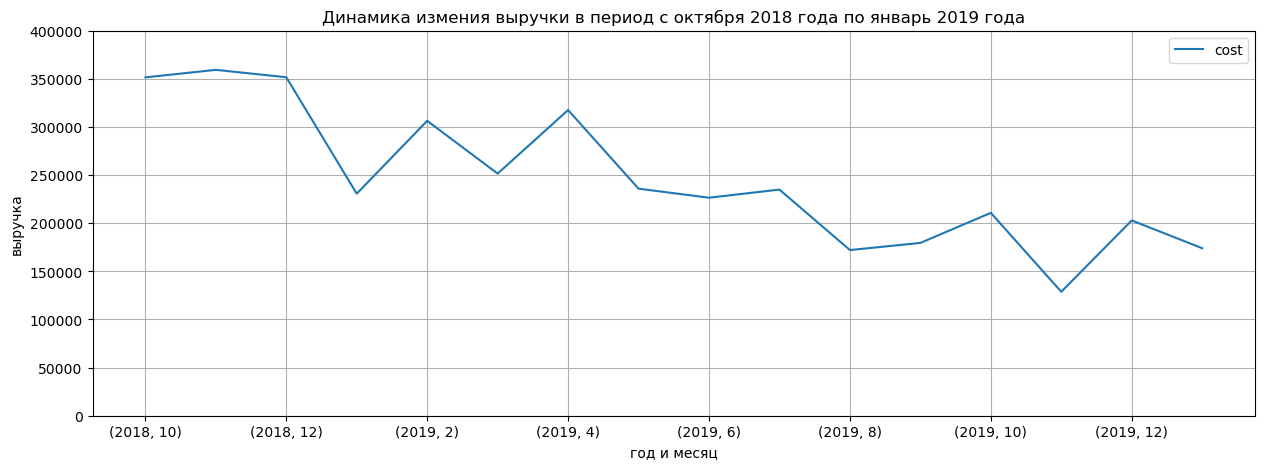

In [72]:
ecom_agg.plot(y=['cost'], grid=True, figsize=(15, 5))
plt.ylabel("выручка")
plt.xlabel("год и месяц")
plt.ylim([0, 400000])
plt.title("Динамика измения выручки в период с октября 2018 года по январь 2019 года");

<div style="border: solid purple 2px; padding: 20px">На графике на протяжении всего исследуемого периода виден спад по выручке. Пиковые значения достигались в самом начале исследуемого периода в октябре-декабре 2018 года, затем видны два пика в феврале и апреле 2019 года, но они не достигали начальных значений. К концу исследуемого периода виден спад, особенно провал заметен в ноябре 2019 года.

### Изменение среднего чека и средней выручки с покупателя

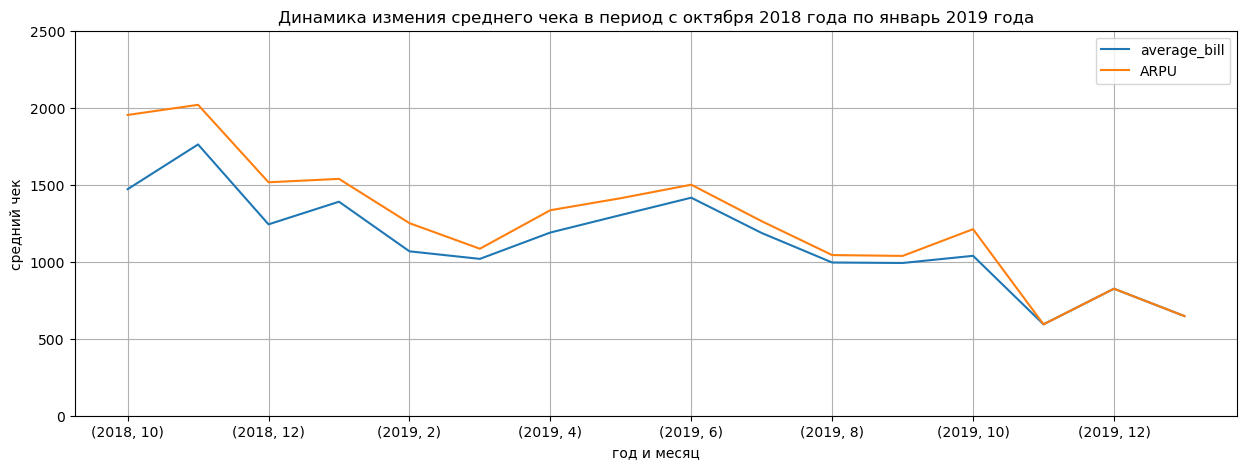

In [73]:
ecom_agg.plot(y=['average_bill','ARPU'], grid=True, figsize=(15, 5))
plt.ylabel("средний чек")
plt.xlabel("год и месяц")
plt.ylim([0, 2500])
plt.title("Динамика измения среднего чека в период с октября 2018 года по январь 2019 года");

<div style="border: solid purple 2px; padding: 20px"> Ситуация со среднем чеком и средней выручклй с покупателя похожа на ситуацию с изменеием выручки, есть пик в ноябре 2018 года, затем пик поменьше в январе и июне 2019 года, но в целом виден сильный спад к концу 2019 года 

### Изменение количества заказов

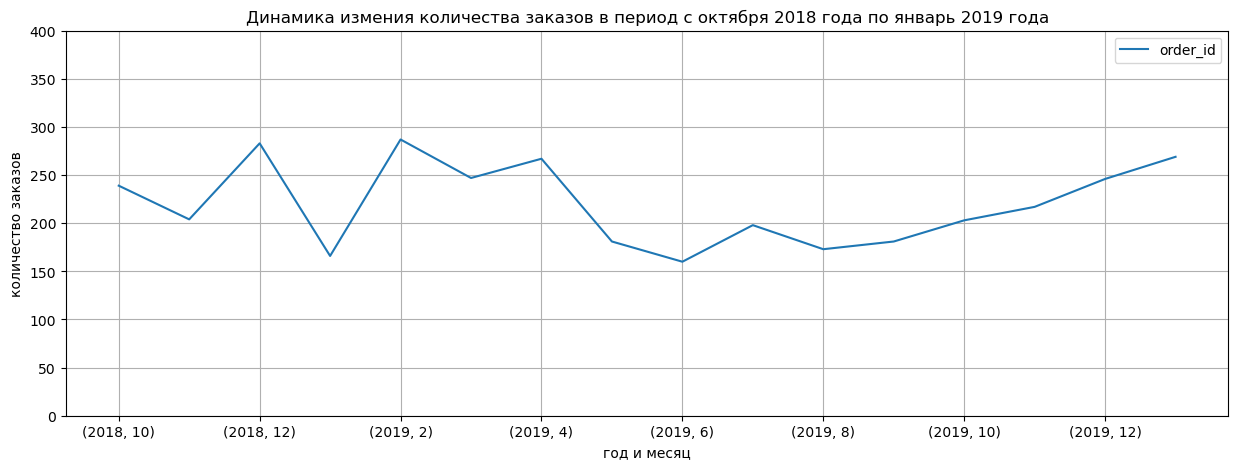

In [74]:
ecom_agg.plot(y='order_id', grid=True, figsize=(15, 5))
plt.ylabel("количество заказов")
plt.xlabel("год и месяц")
plt.ylim([0,400])
plt.title("Динамика измения количества заказов в период с октября 2018 года по январь 2019 года");

<div style="border: solid purple 2px; padding: 20px"> С заказами ситуация другая, есть пик заказов в декабре 2018 года, что сходится с ситуацией по выручке, но средний чек и средняя выручка с покупателя упали (вероятнее всего было сделано много заказов, но не очень дорогих, в связи с праздниками) и есть пик в феврале 2019 года, что опять же, видно и на графике выручки, но не на графике со средним чеком. Несмотря на то, что есть большой провал в июне 2019 года по количеству заказов, показатели среднего чека и средней выручки с покупателя показали рост, что может говорить о том, что было сделано не очень много, но дорогих заказов. И к концу года виден рост количества заказов, хотя все остальные показатели падают. Так как мы знаем, что в среднем пользователи делают один заказ, и, по показателю выручки, чаще не очень дорогой, можно подумать, что есть что-то, что отталкивает пользователей сделать еще один заказ (возможно какие-то сложности с оформлением заказа или получением). 

### Среднее количество товаров в заказе по годам/месяцам

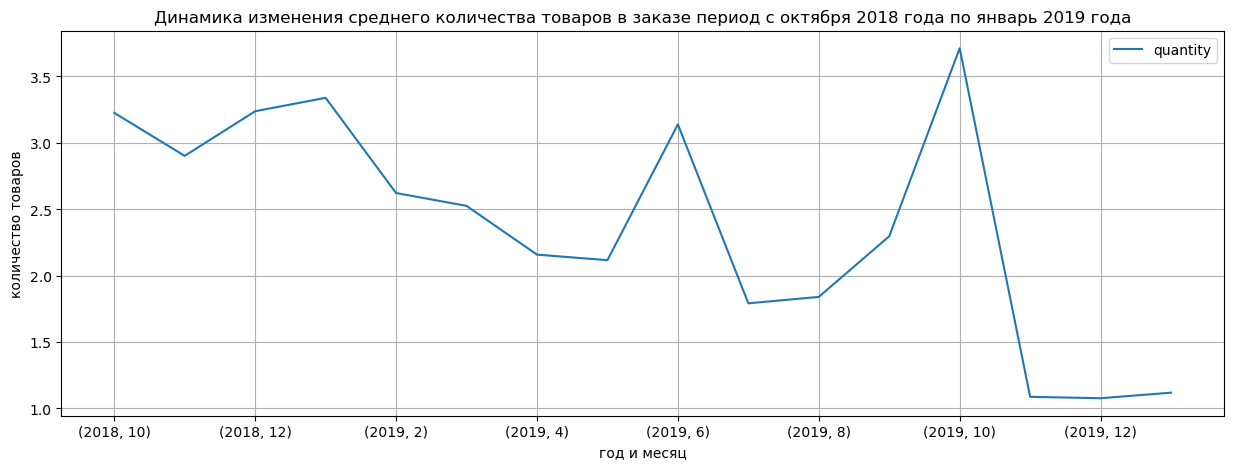

In [75]:
ecom_agg.plot(y='quantity', grid=True, figsize=(15, 5))
plt.ylabel("количество товаров")
plt.xlabel("год и месяц")
plt.title("Динамика изменения среднего количества товаров в заказе период с октября 2018 года по январь 2019 года");

<div style="border: solid purple 2px; padding: 20px"> Количество товаров в заказе резко выросло в июне и октябре 2019 года до трех и трех с половиной товаров, эти пики скорее всего связаны с сезонностью, выделим эти месяца и посмотрим, что чаще всего покупают

In [76]:
ecom.query('month == 10')['category'].value_counts(normalize=True)

растения и саженцы         0.309117
хранение вещей             0.150997
аксессуары для ванны       0.132479
декор и интерьер           0.106838
инвентарь для уборки       0.105413
текстиль                   0.055556
кухонные принадлежности    0.044160
другое                     0.035613
ремонт и строительство     0.034188
посуда                     0.025641
Name: category, dtype: float64

In [77]:
ecom.query('month == 6')['category'].value_counts(normalize=True)

растения и саженцы         0.631944
аксессуары для ванны       0.104167
хранение вещей             0.100694
инвентарь для уборки       0.045139
текстиль                   0.045139
декор и интерьер           0.027778
другое                     0.017361
ремонт и строительство     0.010417
посуда                     0.010417
кухонные принадлежности    0.006944
Name: category, dtype: float64

<div style="border: solid purple 2px; padding: 20px"> Отметим, что и для июня и для октября лидером является категория "растения и саженцы", но если в июня это абсолютный лидер (62,85%), то к октябрю пользователи к "растениям и саженцам" (31,01%) так же покупают товары из категории "хранение вещей" (15,08%) и "аксессуары для ванны" (13,23%). Можно предположить, что летом пользовали заняты только дачей и огородом, а к концу осени больше занимаются обустройством дома.

### Количество купленных товаров разных категорий

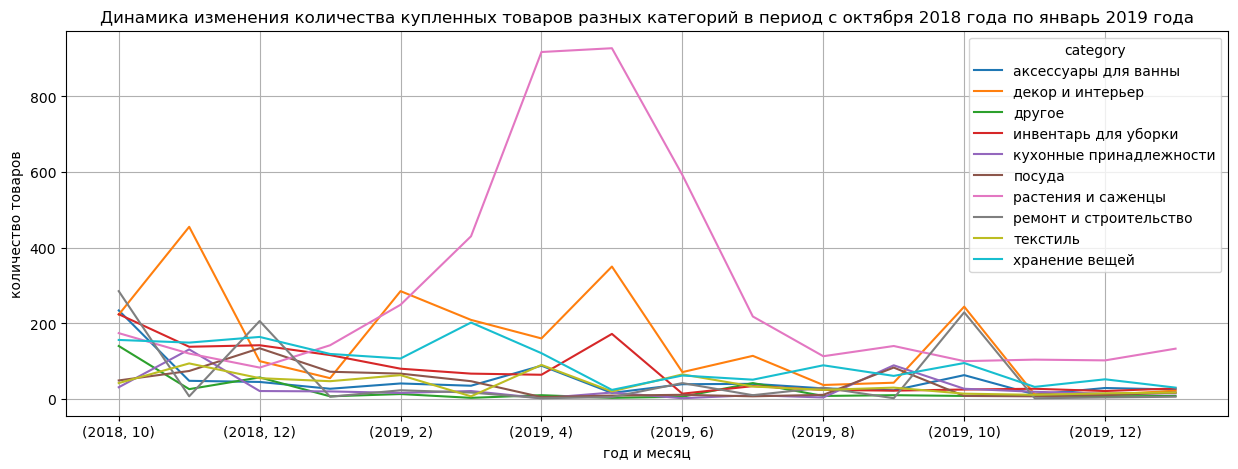

In [78]:
ecom.pivot_table(index=['year','month'], columns='category', values=['quantity'], aggfunc={'quantity': 'sum'})\
.plot(y='quantity', grid=True, figsize=(15, 5))
plt.ylabel("количество товаров")
plt.xlabel("год и месяц")
plt.title("Динамика изменения количества купленных товаров разных категорий в период с октября 2018 года по январь 2019 года");

<div style="border: solid purple 2px; padding: 20px"> Выше мы уже выяснили, что по количеству купленных товаров летом категория "растения и саженцы" - абсолютный лидер, что хорошо видно и на этом графике. Так же хорошо заметны пики категории "декор и интерьер". Много категорий сливаются примерно в одну линию, уберем лидера по количеству товаров и посмотрим на другие категории поближе.

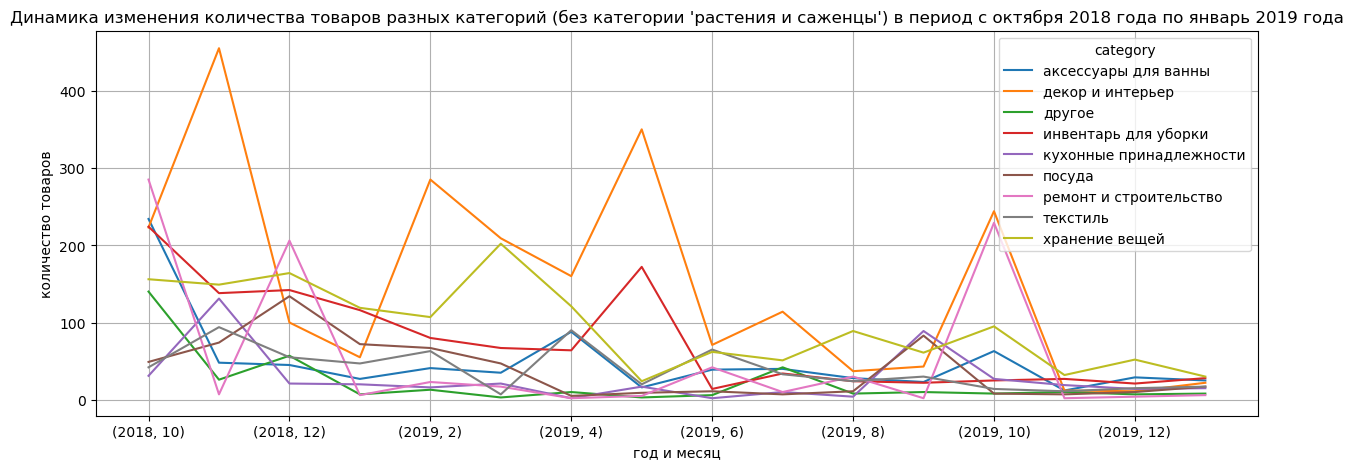

In [79]:
ecom.query('category != "растения и саженцы"').pivot_table(index=['year','month'], columns='category', values=['quantity'], aggfunc={'quantity': 'sum'})\
.plot(y='quantity', grid=True, figsize=(15, 5))
plt.ylabel("количество товаров")
plt.xlabel("год и месяц")
plt.title("Динамика изменения количества товаров разных категорий (без категории 'растения и саженцы') в период с октября 2018 года по январь 2019 года");

<div style="border: solid purple 2px; padding: 20px"> Пользователи практически круглогодично покупают товары "декор и интерьер", есть два интересных пика категории "ремонт и строительство" (декабрь 2018 и октябрь 2019), видимо зимой больше занимаются ремонтом, к началу лета покупают "инвентарь для уборки", а также перед летним сезоном покупают предметы для "хранения вещей"

### Изменение прибыли от товаров  разных категорий

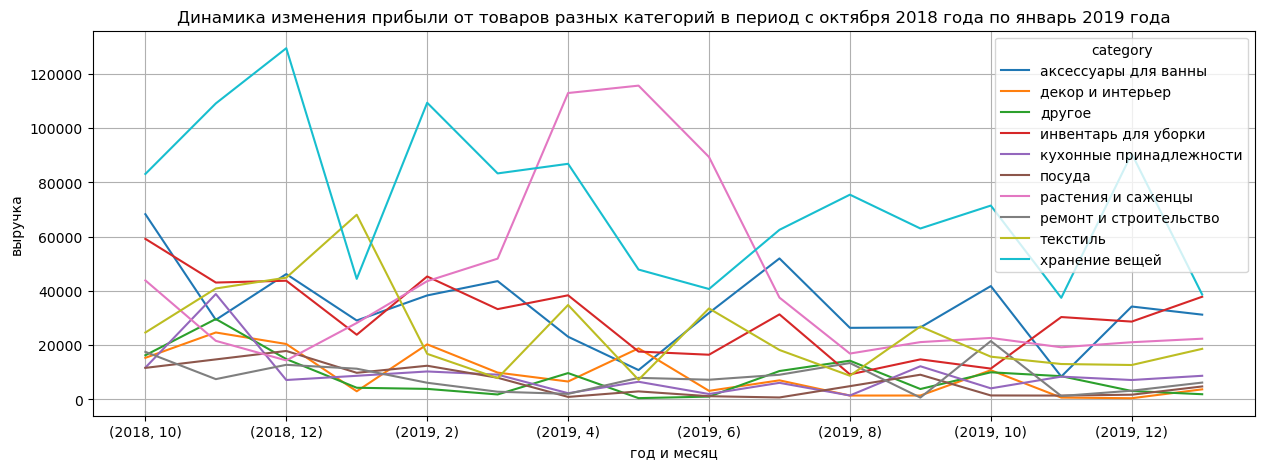

In [80]:
ecom.pivot_table(index=['year','month'], columns='category', values=['cost'], aggfunc={'cost': 'sum'})\
.plot(y='cost', grid=True, figsize=(15, 5));
plt.ylabel("выручка")
plt.xlabel("год и месяц")
plt.title("Динамика изменения прибыли от товаров разных категорий в период с октября 2018 года по январь 2019 года");

Несмотря на лидирующую позицию категории "растения и саженцы" по количеству товаров, с ней по прибыли практически равняется категория "хранение вещей" 

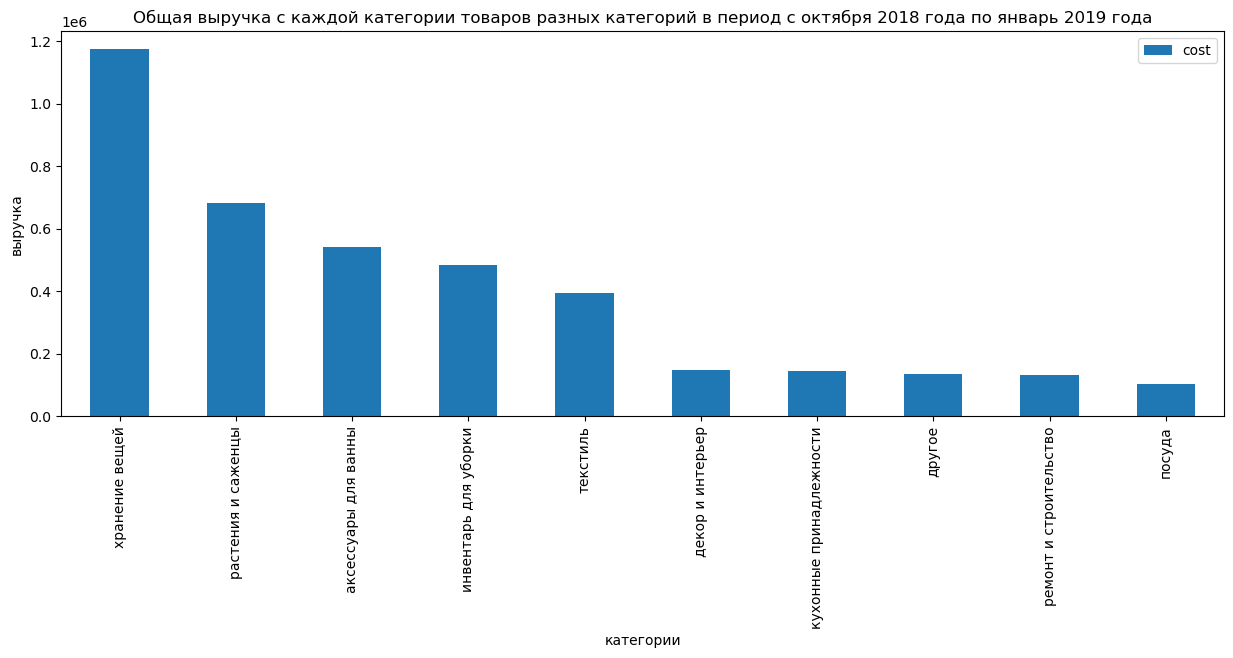

In [81]:
ecom.pivot_table(index=['category'], values=['cost'], aggfunc={'cost': 'sum'}).sort_values(by='cost', ascending=False)\
.plot(y='cost', kind='bar', figsize=(15, 5));
plt.ylabel("выручка")
plt.xlabel("категории")
plt.title("Общая выручка с каждой категории товаров разных категорий в период с октября 2018 года по январь 2019 года");

<div style="border: solid purple 2px; padding: 20px"> Как оказалось, категория "хранение вещей" принесла практически кратно больше категории "растения и саженцы", а меньше всего принесли денег категории "ремонт и строительство" и  "посуда".

### Количество купленых товаров разных ценовых категорий

Возможно есть смысл рассмотреть, товары каких категорий чаще всего относят к каждой ценовой категории

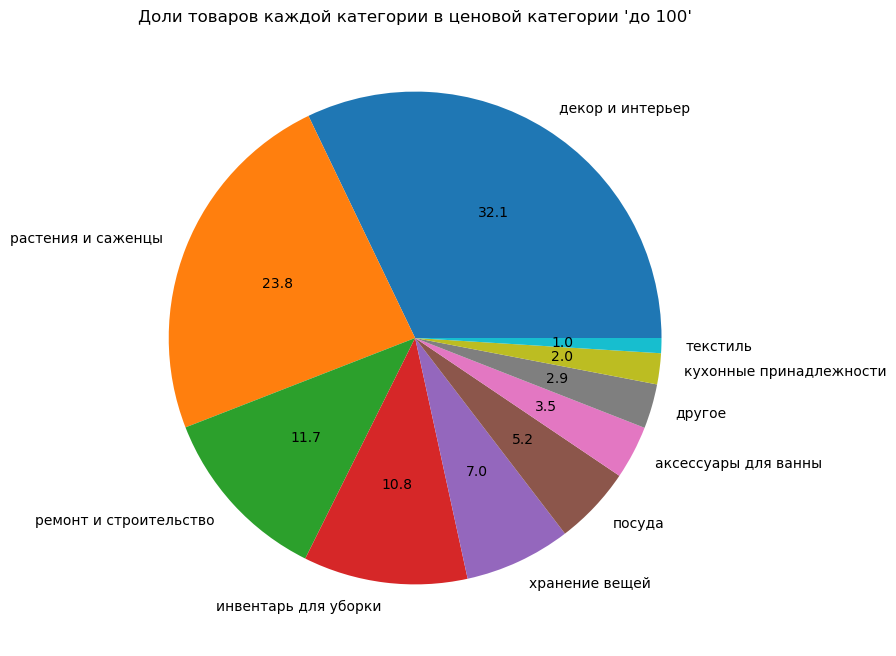

In [82]:
ecom.query('price_category =="до 100"').pivot_table(index=['category'], values=['quantity'], aggfunc={'quantity': 'sum'})\
.sort_values(by='quantity', ascending=False)\
.plot(y='quantity', kind='pie', autopct='%.1f', figsize = (15,8), legend=False).set(ylabel='')
plt.title("Доли товаров каждой категории в ценовой категории 'до 100'");

<div style="border: solid purple 2px; padding: 20px">Для товаров "до 100" лидером является категория "декор и интерьер" (32,1%), а так же "растения и саженцы" (23,8%), меньше всего занимают в этой ценовой категории товары категории "текстиль" (1,0%).

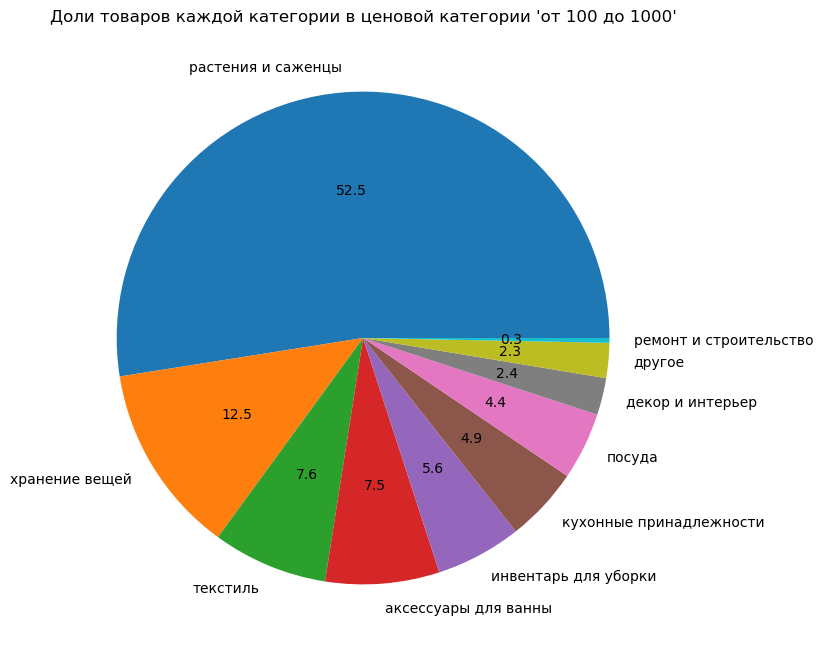

In [83]:
ecom.query('price_category =="от 100 до 1000"').pivot_table(index=['category'], values=['quantity'], aggfunc={'quantity': 'sum'}).sort_values(by='quantity', ascending=False)\
.plot(y='quantity', kind='pie', autopct='%.1f', figsize = (15,8), legend=False).set(ylabel='')
plt.title("Доли товаров каждой категории в ценовой категории 'от 100 до 1000'");

<div style="border: solid purple 2px; padding: 20px">У ценовой категории "от 100 до 1000" лидер по количеству проданных товаров - "растения и саженцы" (52,5%), так же заметная часть приходится на "хранение вещей" и "текстиль" (12,5% и 7,6% соответственно). Меньше всего в этой ценовой категории продано товаров категории "ремонт и строительство" - 0,3%

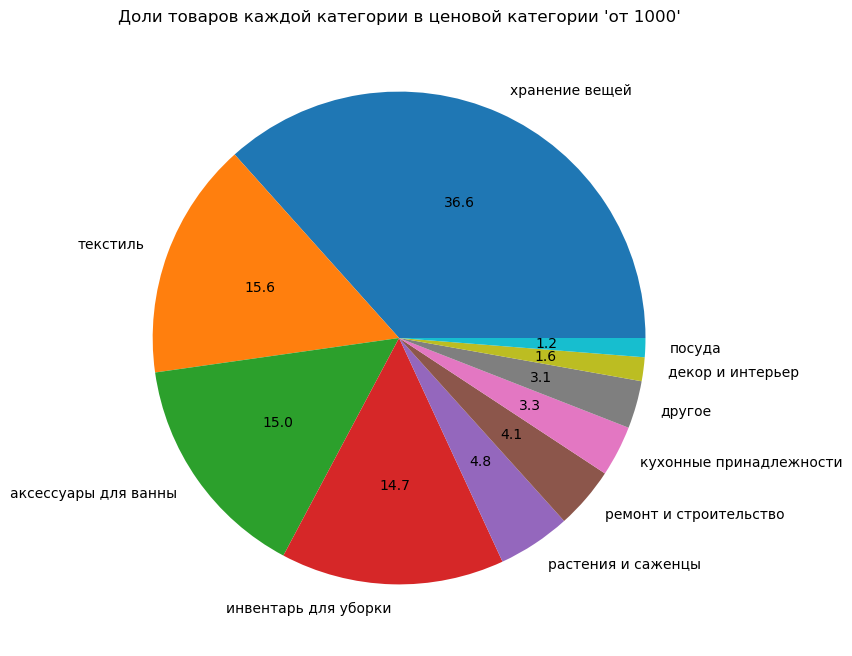

In [84]:
ecom.query('price_category =="от 1000"').pivot_table(index=['category'], values=['quantity'], aggfunc={'quantity': 'sum'}).sort_values(by='quantity', ascending=False)\
.plot(y='quantity', kind='pie', autopct='%.1f', figsize = (15,8), legend=False).set(ylabel='')
plt.title("Доли товаров каждой категории в ценовой категории 'от 1000'");

<div style="border: solid purple 2px; padding: 20px">Лидер этой ценовой категории по количеству проданных товаров - товары категории "хранение вещей" (36,6%), затем идут товары из категории "текстиль" (15,6%) и "аксессуары для ванны" (16,2%), а так же инвентарь для уборки (14,7%). Меньше всего товаров категории "посуда" (1,2%).

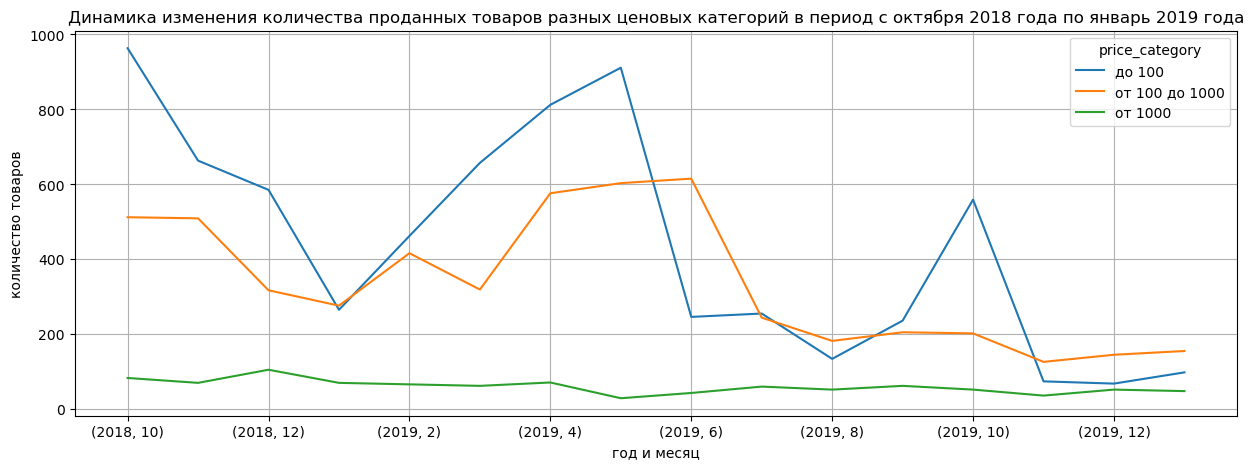

In [85]:
ecom.pivot_table(index=['year','month'], columns='price_category', values=['quantity'], aggfunc={'quantity': 'sum'})\
.plot(y='quantity', grid=True, figsize=(15, 5))
plt.ylabel("количество товаров")
plt.xlabel("год и месяц")
plt.title("Динамика изменения количества проданных товаров разных ценовых категорий в период с октября 2018 года по январь 2019 года");

<div style="border: solid purple 2px; padding: 20px"> Много товаров категории "до 100" было куплено в начале лета 2019 года, что согласуется с теорией о том, что пользователи покупают рассаду для дачи и много. Так же есть пик покупки таких товаров в октябре 2019, что связано и с пиком покупки товаров "декор и интерьер". Товаров ценовыой категории "от 1000" стабильно покупают немного, а у товаров "от 100 до 1000" есть небольшой и плавный пик в с апреля по июнь 2019 года, однако потом происходит спад в июле 2019 года и количество проданных товаров этой категории практически не меняется.

### Изменение прибыли от товаров  разных ценовых категорий

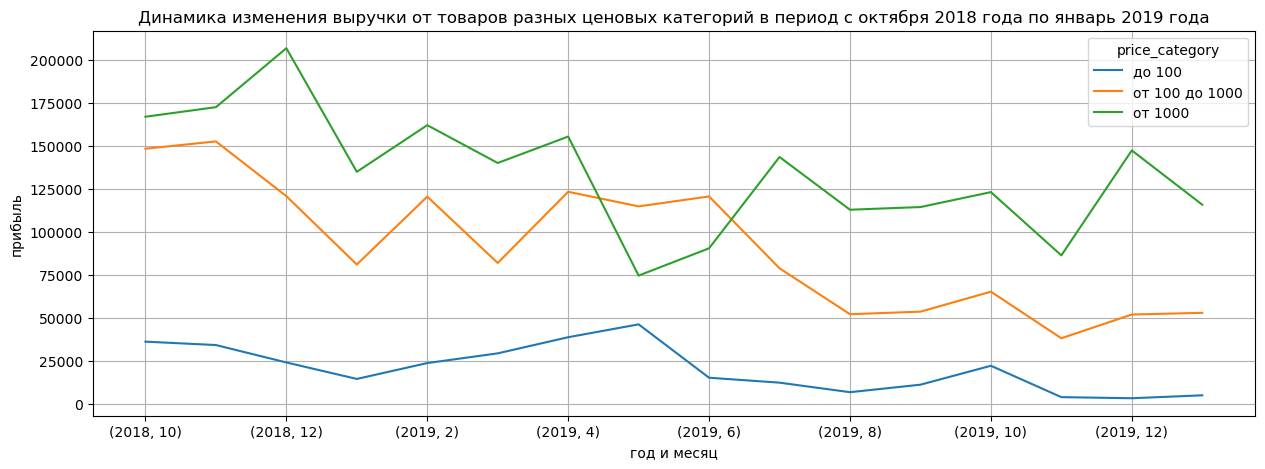

In [86]:
ecom.pivot_table(index=['year','month'], columns='price_category', values=['cost'], aggfunc={'cost': 'sum'})\
.plot(y='cost', grid=True, figsize=(15, 5));
plt.ylabel("прибыль")
plt.xlabel("год и месяц")
plt.title("Динамика изменения выручки от товаров разных ценовых категорий в период с октября 2018 года по январь 2019 года");

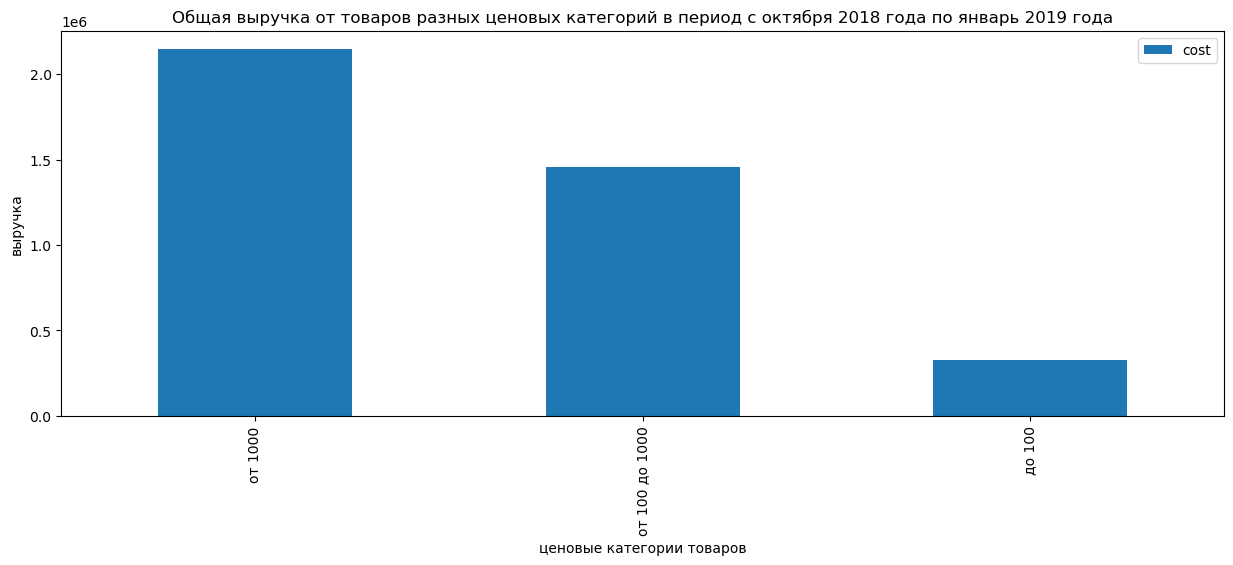

In [87]:
ecom.pivot_table(index=['price_category'], values=['cost'], aggfunc={'cost': 'sum'}).sort_values(by='cost', ascending=False)\
.plot(y='cost', kind='bar', figsize=(15, 5))
plt.ylabel("выручка")
plt.xlabel("ценовые категории товаров")
plt.title("Общая выручка от товаров разных ценовых категорий в период с октября 2018 года по январь 2019 года");

<div style="border: solid purple 2px; padding: 20px">Несмотря на то, что товаров "от 1000" покупают сравнимо меньше, чем всех остальных, прибыли они принесли больше. Так же это согласуется с тем, что лидер этой ценовой категории - товары "хранение вещей" - принесли больше всего денег.

## Сегментация покупателей по профилю потребления

### По количеству заказов

Проведем разделение пользователей на тех, кто сделал только один заказ и тех, кто сделал больше одного. Создадим список тех пользователей, которые сделали больше одного заказа

In [88]:
more_then_1_order_user_list= ecom.pivot_table(index=['customer_id'], values=['order_id'],\
                                              aggfunc={'order_id': 'nunique'}).query('order_id > 1').index

Создадим функцию, которая присвоит категорию "А" если пользователем было сделано больше одного заказа, и категорию "В" если был сделан только один заказ. Для этого будем искать уникальный идентификатор пользователя в списке, созданом выше, и если пользователь там есть, то определяем его в категорию "А", если нет, то в категорию "В"

In [89]:
def categorize_by_orders(user_id):
    if user_id in more_then_1_order_user_list:
        return 'A'
    return 'B'

In [90]:
ecom['category_by_orders'] = ecom['customer_id'].apply(categorize_by_orders)

In [91]:
ecom.head() #проверка

,index,date,customer_id,order_id,product,quantity,price,year,month,cost,category,price_category,category_by_orders
0,0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,2018,10,142.0,растения и саженцы,от 100 до 1000,B
1,1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.0,2018,10,194.0,растения и саженцы,от 100 до 1000,B
2,2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,2018,10,112.0,растения и саженцы,от 100 до 1000,B
3,3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0,2018,10,179.0,растения и саженцы,от 100 до 1000,B
4,4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0,2018,10,112.0,растения и саженцы,от 100 до 1000,B


Посмотрим на количество пользователей в каждой категории 

In [92]:
ecom.pivot_table(index=['customer_id'], values=['category_by_orders'], aggfunc={'category_by_orders':'first'}).value_counts()

category_by_orders
B                     1545
A                      884
dtype: int64

<div style="border: solid purple 2px; padding: 20px">Все соотносится с тем, что большинство пользователей делает один заказ

### По средней цене товаров, которые покупает пользователь

Посчитаем среднюю цену товаров, которые покупает каждый пользователь и на основании этого присвоим ему категорию 

In [93]:
mean_price = ecom.pivot_table(index=['customer_id'], values=['price'], aggfunc={'price': 'mean'}).reset_index()

In [94]:
mean_price.head()

,customer_id,price
0,000d6849-084e-4d9f-ac03-37174eaf60c4,138.75
1,001cee7f-0b29-4716-b202-0042213ab038,442.00
2,00299f34-5385-4d13-9aea-c80b81658e1b,457.00
3,002d4d3a-4a59-406b-86ec-c3314357e498,1649.00
4,003bbd39-0000-41ff-b7f9-2ddaec152037,1162.00


Создадим функцию, которая присвоит категории пользователям:
- средняя цена покупаемых товаров меньше 500: "c"
- средняя цена покупаемых товаров от 500 до 1000: "b"
- средняя цена покупаемых товаров больше 1000: "a"

In [95]:
def categorize_by_mean_price(user_id):
    price = mean_price[mean_price['customer_id']==user_id]['price'].values[0]
    if price < 500:
        return 'c'
    elif 500 <= price <= 1000:
        return 'b'
    elif 1000 < price: 
        return 'a'

In [96]:
ecom['category_by_mean_price'] = ecom['customer_id'].apply(categorize_by_mean_price)

In [97]:
ecom.head() # проверка

,index,date,customer_id,order_id,product,quantity,price,year,month,cost,category,price_category,category_by_orders,category_by_mean_price
0,0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,2018,10,142.0,растения и саженцы,от 100 до 1000,B,c
1,1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.0,2018,10,194.0,растения и саженцы,от 100 до 1000,B,c
2,2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,2018,10,112.0,растения и саженцы,от 100 до 1000,B,c
3,3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0,2018,10,179.0,растения и саженцы,от 100 до 1000,B,c
4,4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0,2018,10,112.0,растения и саженцы,от 100 до 1000,B,c


Объединим две категории в одну в отдельном столбце

In [98]:
ecom['profile_category'] = ecom['category_by_orders']+ecom['category_by_mean_price']

<div style="border: solid purple 2px; padding: 20px">
    
Расшифровка профилей пользователей:
- "Aa": пользователь сделал больше одного заказа, средняя цена купленных товаров больше 1000
- "Ab": пользователь сделал больше одного заказа, средняя цена купленных товаров от 500 до 1000
- "Ac": пользователь сделал больше одного заказа, средняя цена купленных товаров меньше 500
- "Ba": пользователь сделал один заказ, средняя цена купленных товаров больше 1000
- "Bb": пользователь сделал один заказ, средняя цена купленных товаров от 500 до 1000
- "Bc": пользователь сделал один заказ, средняя цена купленных товаров меньше 500

Сделаем попарные сравнения категорий ("Bc" "Ac", "Аа" "Ас" и "Ва" "Вс")

In [99]:
profile_category_list=['Aa', 'Ba', 'Ab', 'Bb', 'Ac', 'Bc']

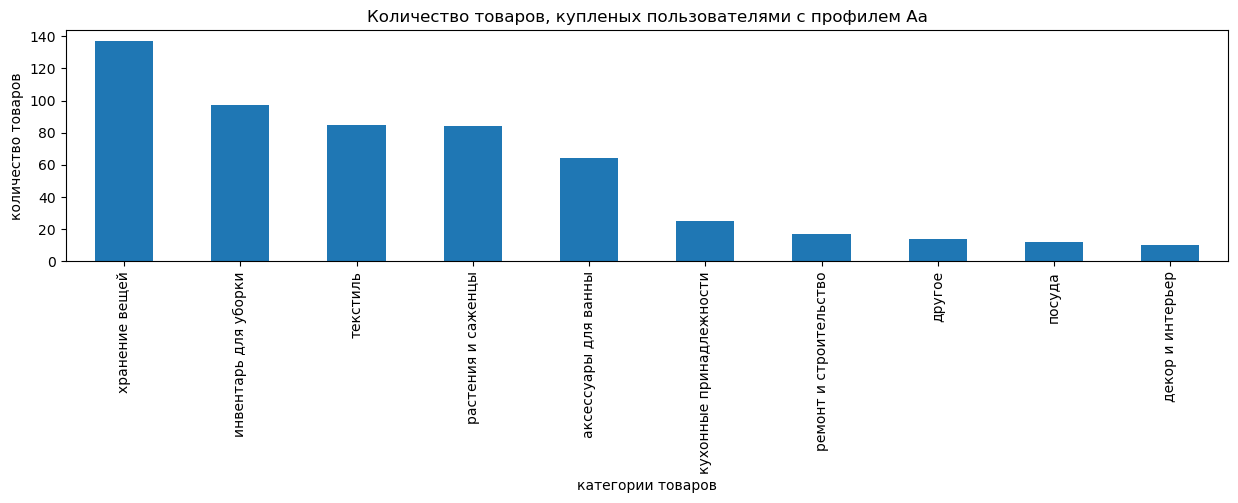

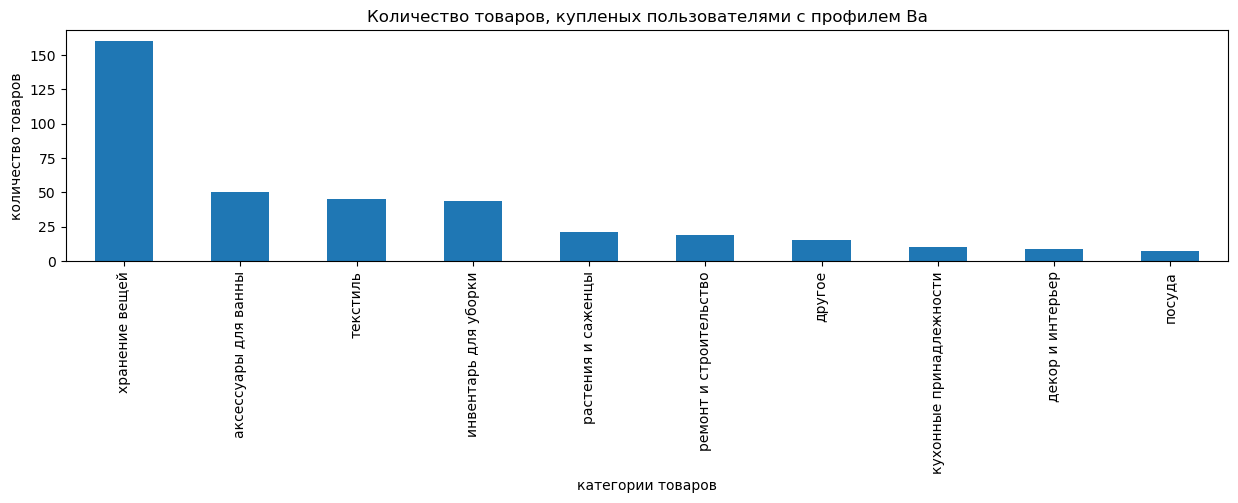

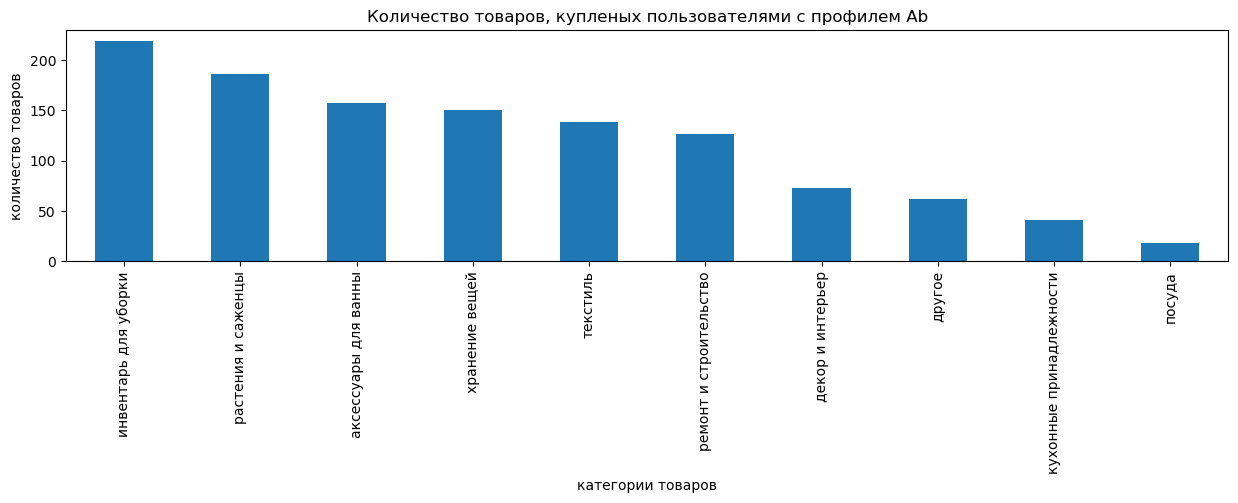

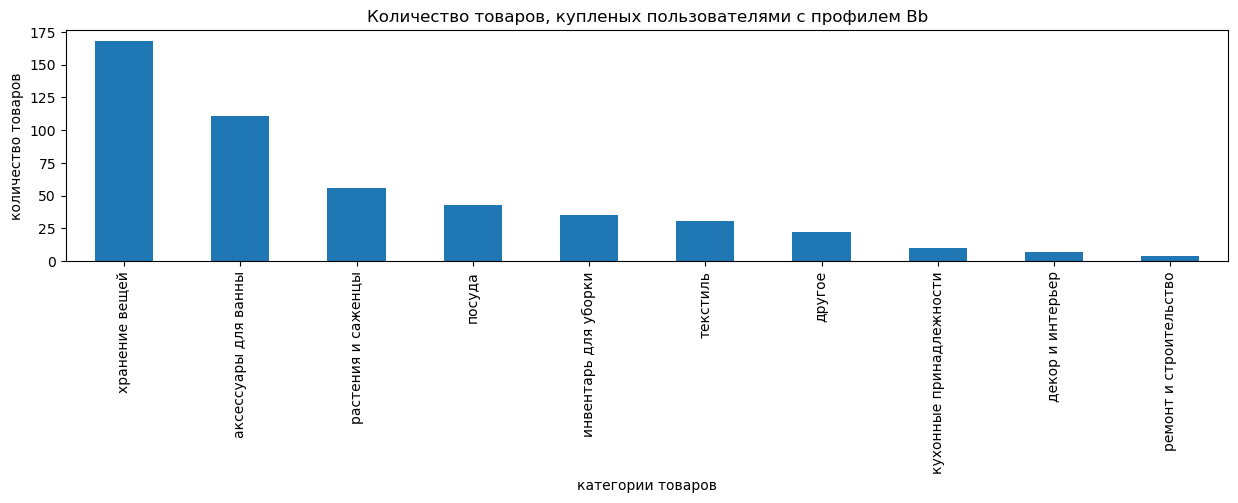

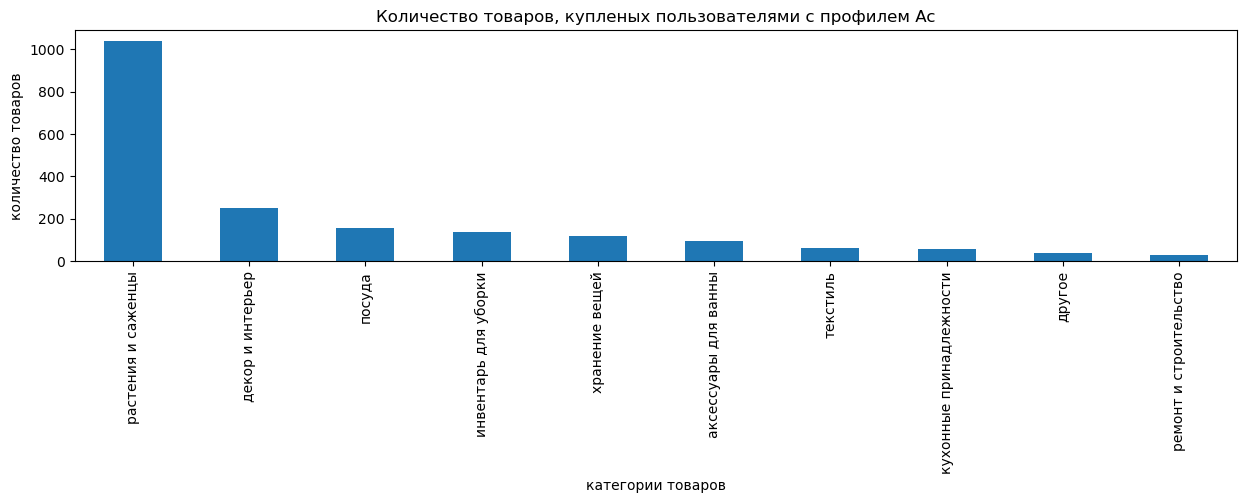

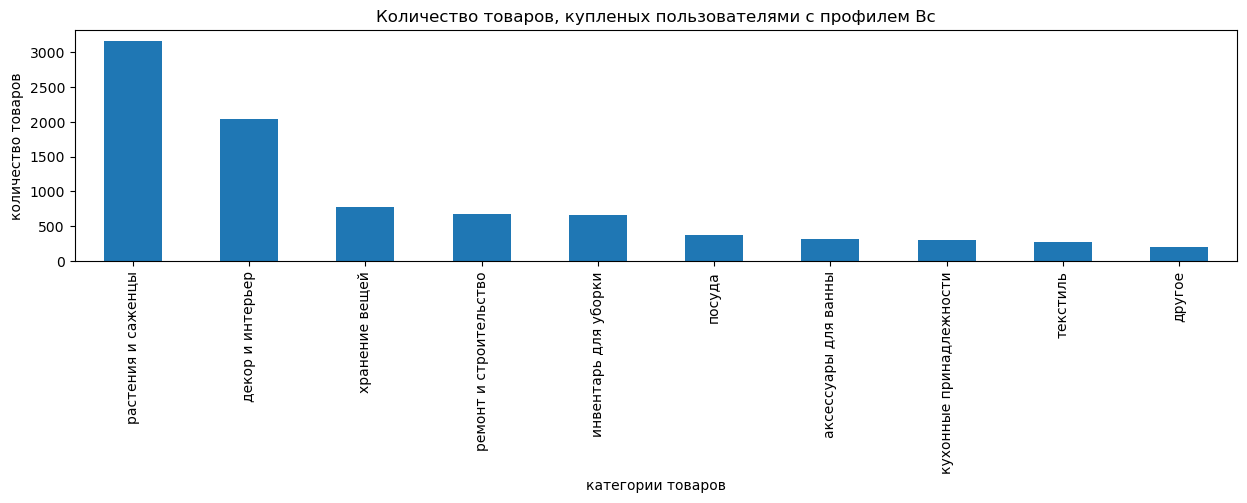

In [100]:
for c in profile_category_list:
    customer_list = ecom[ecom['profile_category']==c]['customer_id'].unique()
    ecom.query('customer_id in @customer_list').pivot_table(index=['category'], values=['quantity'], aggfunc={'quantity': 'sum'})\
    .sort_values(by='quantity', ascending=False).plot(kind='bar', figsize = (15,3), legend=False,\
title=f'Количество товаров, купленых пользователями c профилем {c}').set(xlabel='категории товаров', ylabel='количество товаров');
    plt.show()

<div style="border: solid purple 2px; padding: 20px">
    
- Пользователи с профилем "Аа" и "Ва" больше всего покупают товаров из категории "хранение вещей" (что закономерно. ведь они принесли больше всего выручки,соответсвенно стоят больше всего). На втором месте категория "аксессуары для ванны". 
- Пользователи с профилем "Ab"  больше всего покупают товаров из категории "инвентарь для уборки" "растения и саженцы".
- Пользователи с профилем "Bb" больше всего покупают товаров из категории "хранение вещей" и "аксессуары для ванны".
- Пользователи с профилем "Ас" и Вс больше всего покупают товаров из категории "растения и саженцы".   

## Проверка гипотез

### Отличается ли средняя выручка на покупателя из разных сегментов?

Создадим агрегированные таблицы для каждой категории с выручкой, количеством заказов, количеством пользователей, количеством товаров, средним чеком и средней помесячной выручкой с пользователя. Для этого немного изменим функцию table_aggregation

In [101]:
def table_aggregation(table):
    table_agg = table.pivot_table(index=['year', 'month'], values=['customer_id','order_id','cost','quantity'],\
                                    aggfunc={'order_id':'nunique','cost':sum, 'customer_id':'nunique', 'quantity':'sum'})
    table_agg['cost'] = np.ceil(table_agg['cost'])
    table_agg['average_bill'] = table_agg['cost']/table_agg['order_id']
    table_agg['ARPU'] = table_agg['cost']/table_agg['customer_id']
    return table_agg

In [102]:
Aa_agg = table_aggregation(ecom.query('profile_category == "Aa"'))

In [103]:
Ab_agg = table_aggregation(ecom.query('profile_category == "Ab"'))

In [104]:
Ac_agg = table_aggregation(ecom.query('profile_category == "Ac"'))

In [105]:
Ba_agg = table_aggregation(ecom.query('profile_category == "Ba"'))

In [106]:
Bb_agg = table_aggregation(ecom.query('profile_category == "Bb"'))

In [107]:
Bc_agg = table_aggregation(ecom.query('profile_category == "Bc"'))

Cформулируем гипотезы

0. Нулевая гипотеза: средняя помесячная выручка с покупателей категории "Ac" равна средней помесячной выручке с покупателей категории "Bc"
1. Альтернативная гипотеза: средняя помесячная выручка с покупателей категории "Ac" не равна помесячной выручке с покупателей категории "Bc"

In [108]:
alpha = 0.05 
results = st.ttest_ind(Bc_agg['ARPU'], Ac_agg['ARPU'],  alternative='two-sided')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 

p-значение: 0.013700394398858886
Отвергаем нулевую гипотезу


<div style="border: solid red 2px; padding: 20px">
<u>Нулевая гипотеза</u> о том, что средняя помесячная выручка с покупателей категории "Ac" равна средней помесячной выручке с покупателей категории "Bc" <b>отвергнута</b>.

Cформулируем гипотезы

0. Нулевая гипотеза: средняя помесячная выручка с покупателей категории "Aa" равна средней помесячной выручке с покупателей категории "Ba"
1. Альтернативная гипотеза: средняя помесячная выручка с покупателей категории "Aa" не равна средней помесячной выручке с покупателей категории "Ba"

In [109]:
alpha = 0.05 
results = st.ttest_ind(Aa_agg['ARPU'], Ba_agg['ARPU'],  alternative='two-sided')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 

p-значение: 0.2563317568419614
Не отвергаем нулевую гипотезу


<div style="border: solid green 2px; padding: 20px">
<u>Нулевая гипотеза</u> о том, что средняя помесячная выручка с покупателей категории "Aa" равна средней помесячной выручке с покупателей категории "Ba" <b>не отвергается</b>.

Cформулируем гипотезы

0. Нулевая гипотеза: средняя помесячная выручка с покупателей категории "Ab" равна средней помесячной выручке с покупателей категории "Bb"
1. Альтернативная гипотеза: средняя помесячная выручка с покупателей категории "Ab" не равна средней помесячной выручке с покупателей категории "Bb"

In [110]:
alpha = 0.05 
results = st.ttest_ind(Ab_agg['ARPU'], Bb_agg['ARPU'],  alternative='two-sided')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 

p-значение: 0.33957325191571774
Не отвергаем нулевую гипотезу


<div style="border: solid green 2px; padding: 20px">
<u>Нулевая гипотеза</u> о том, что средняя помесячная выручка с покупателей категории "Ab" равна средней помесячной выручке с покупателей категории "Bb" <b>не отвергается</b>.

<div style="border: solid purple 2px; padding: 20px">Можно сделать вывод о том, что пользователи категории "Ac" (сделал больше одного заказа, средняя цена купленных товаров меньше 500) и пользователи категории "Bc" (сделал один заказ, средняя цена купленных товаров меньше 500) приносят разное количество прибыли, для всех остальных попарных сравнений ("Aa" "Ba" и "Ab" "Bb") cтатистической разницы между средней выручкой не наблюдается.

### Отличается ли  количество товаров, купленых пользователями из разных сегментов?

Cформулируем гипотезы

0. Нулевая гипотеза: среднее количество товаров, купленных клиентами категории "Ac" равно среднему количеству товаров, купленных клиентами категории "Bc"
1. Альтернативная гипотеза: среднее количество товаров, купленных клиентами категории "Ac" не равно среднему количеству товаров, купленных клиентами категории "Bc"

In [111]:
alpha = 0.05 
results = st.ttest_ind(Ac_agg['quantity'], Bc_agg['quantity'], alternative='two-sided')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 

p-значение: 0.00013671973023676314
Отвергаем нулевую гипотезу


<div style="border: solid red 2px; padding: 20px">
<u>Нулевая гипотеза</u> о том, что количество товаров, купленных клиентами категории "Ac" равно количеству товаров, купленных клиентами категории "Bc" <b>отвергнута</b>.

Cформулируем гипотезы

0. Нулевая гипотеза: количество товаров, купленных клиентами категории "Ab" равно количеству товаров, купленных клиентами категории "Bb"
1. Альтернативная гипотеза: количество товаров, купленных клиентами категории "Ab" не равно количеству товаров, купленных клиентами категории "Bb"

In [112]:
alpha = 0.05 
results = st.ttest_ind(Ab_agg['quantity'], Bb_agg['quantity'], alternative='two-sided')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 

p-значение: 0.1623203087517901
Не отвергаем нулевую гипотезу


<div style="border: solid green 2px; padding: 20px">
<u>Нулевая гипотеза</u> о том, что количество товаров, купленных клиентами категории "Ab" равно количеству товаров, купленных клиентами категории "Bb" <b>не отвергается</b>.

Cформулируем гипотезы

0. Нулевая гипотеза: количество товаров, купленных клиентами категории "Aa" равно количеству товаров, купленных клиентами категории "Ba"
1. Альтернативная гипотеза: количество товаров, купленных клиентами категории "Aa" не равно количеству товаров, купленных клиентами категории "Ba"

In [113]:
alpha = 0.05 
results = st.ttest_ind(Aa_agg['quantity'], Ba_agg['quantity'], alternative='two-sided')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 

p-значение: 0.3073774775725118
Не отвергаем нулевую гипотезу


<div style="border: solid green 2px; padding: 20px">
<u>Нулевая гипотеза</u> о том, количество товаров, купленных клиентами категории "Aa" равно количеству товаров, купленных клиентами категории "Ba" <b>не отвергается</b>.

<div style="border: solid purple 2px; padding: 20px">
Можно сделать вывод о том, что пользователи категории "Ac" (сделал больше одного заказа, средняя цена купленных товаров меньше 500) и пользователи категории "Bc" (сделал один заказ, средняя цена купленных товаров меньше 500) покупали разное количество товаров, для всех остальных попарных сравнений ("Aa" "Ba" и "Ab" "Bb") cтатистической разницы между количеством товаров для обеих категорий не наблюдается.

## Выводы и рекомендации

<div style="border: solid purple 2px; padding: 20px">
    
1. Всего за исследуемый период 2427 уникальных покупателя. В ноябре 2019 года виден резкий спад новых покупающих пользователей, однако в целом количество заказов в конце исследуемого периода растет, что может говорить о каких-то сложностях для новых пользователей в оформлении заказа. 

3. Практически половина всех предоставляемых товаров это товары, относящиеся к категории "растения и саженцы". Большинство товаров относится к ценовой категории "от 100 до 1000". 

4. Всего сделано 3158 заказов, чаще всего один пользователь делает один заказ.

5. На графике на протяжении всего исследуемого периода виден спад по выручке, среднему чеку и средней выручке с покупателя. С заказами ситуация другая, к концу года количество заказов растет, но эти заказы от "старых" пользователей

5. Пики по количеству заказов скорее всего связаны с сезонностью, для мая и для октября лидером является категория "растения и саженцы",  к октябрю пользователи к "растениям и саженцам" так же покупают товары из категории "хранение вещей" и "аксессуары для ванны". Можно предположить, что летом пользовали заняты только дачей и огородом, а к концу осени больше занимаются обустройством дома.

6. Категория "хранение вещей" принесла практически кратно больше категории "растения и саженцы".

7. Для товаров "до 100" лидером является категория "декор и интерьер", у ценовой категории "от 100 до 1000" лидер по количеству проданных товаров - "растения и саженцы", а у категории "от 1000" лидер  - товары категории "хранение вещей".

7. Пользователи категории "Ac" (сделал больше одного заказа, средняя цена купленных товаров меньше 500) и пользователи категории "Bc" (сделал один заказ, средняя цена купленных товаров меньше 500) приносят разное количество прибыли и покупают разное количество товаров,  для всех остальных попарных сравнений ("Aa" "Ba" и "Ab" "Bb") статистической разницы для этих двух показателей не наблюдается.    

Рекомендации для пользователей по их профилю: 

- "Aa" (пользователь сделал больше одного заказа, средняя цена купленных товаров больше 1000): 
    - удержать пользователя (предложить скидки на товары из категории "хранение вещей" и "аксессуары для ванны")
- "Ab" (пользователь сделал больше одного заказа, средняя цена купленных товаров от 500 до 1000):
    - удержать пользователя (предложить скидки на товары из категории "инвентарь для уборки" и "растения и саженцы"(но помнить, что категория "растения и саженцы" не самая прибыльная))
- "Ac" (пользователь сделал больше одного заказа, средняя цена купленных товаров меньше 500):
    - удержать пользователя (предложить скидки на товары из категории "растения и саженцы");
    - попытаться стимулировать на покупки товаров из других прибыльных категории ("хранение вещей", "аксессуары для ванны", "инвентарь для уборки")
- "Ba" (пользователь сделал один заказ, средняя цена купленных товаров больше 1000):
    - стимулировать второй заказ (рассылка с предложениями на почту/телефон)
    - предложить скидки или рекламировать товары из категории "хранение вещей" и "аксессуары для ванны" 
- "Bb" (пользователь сделал один заказ, средняя цена купленных товаров от 500 до 1000):
    - стимулировать второй заказ (рассылка с предложениями на почту/телефон)
    - предложить скидки или рекламировать товары из категории "хранение вещей" и "аксессуары для ванны"
- "Bc" (пользователь сделал один заказ, средняя цена купленных товаров меньше 500):
    - стимулировать второй заказ (рассылка с предложениями на почту/телефон)
    - попытаться стимулировать на покупки товаров из других прибыльных категории ("хранение вещей", "аксессуары для ванны", "инвентарь для уборки")
    
    
Общие рекомендации:
- Разобраться, почему с ноября 2019 года практически нет новых заказывающих пользователей
- Стоит обязательно обратить внимание на проблему повторной выгрузки и на повторение уникальных идентификаторов заказов.
- Летом сделать упор на продажу товаров из категории "растения и саженцы", в другие сезоны - на "хранение вещей", "аксессуары для ванны", "инвентарь для уборки" 
- Увеличить количество пользователей, покупающих повторно (предлагать скидку на первый-второй заказ)
- Добавить больше товаров категории "хранение вещей", "аксессуары для ванны" и "инвентарь для уборки" 